In [1]:
import numpy as np
import mnist
from skimage import transform
import skopt
import os

import matplotlib.pyplot as plt
%matplotlib inline

(6000, 28, 28)
(1000, 28, 28)


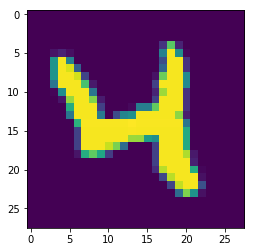

In [2]:
X_train, y = mnist.read(dataset='training', path=os.getcwd()+'/data/')
X_train = X_train.reshape(-1, 28, 28)
X_test, y_test = mnist.read(dataset='testing', path=os.getcwd()+'/data/')
X_test = X_test.reshape(-1, 28, 28)

X_train = X_train.astype('float')/255.0
X_test = X_test.astype('float')/255.0


X_train = X_train[range(0,len(X_train),10),:,:]
X_test = X_test[range(0,len(X_test),10),:,:]
y_test = y_test[range(0,len(X_test),10)]

print(X_train.shape)
print(X_test.shape)
plt.imshow(X_train[2])

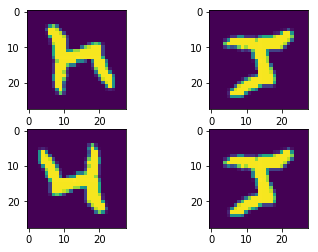

In [3]:
image_datas = [transform.rotate(X_train[2],angle) for angle in [-180,90,0,90]]
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(image_datas[0])
axarr[0,1].imshow(image_datas[1])
axarr[1,0].imshow(image_datas[2])
axarr[1,1].imshow(image_datas[3])

In [4]:
def generate_data(angle):
    """Rotate all images
    **Parameters**
        :alpha: float; Rotation angle in degrees in counter-clockwise direction.
    """
    X_train_r = np.array([transform.rotate(img,angle) for img in X_train])
    X_test_r = np.array([transform.rotate(img,angle) for img in X_test])    
    return X_train_r, X_test_r

In [5]:
%%time
X_train_90, X_test_90 = generate_data(90.0)

CPU times: user 1.79 s, sys: 36 ms, total: 1.82 s
Wall time: 1.81 s


In [6]:
from sklearn.metrics import log_loss,accuracy_score
def lower_bound_value(model,angle):
    """Find a value of classifier in point
    **Parameters**
        :model: model with functions fit/predict_proba
        :alpha: float; Rotation angle in degrees in counter-clockwise direction.
    """
    X_train_r,X_test_r = generate_data(angle)
    y_train = np.zeros(X_train.shape[0])
    y_train_r = np.ones(X_train_r.shape[0])
    y_test = np.zeros(X_test.shape[0])
    y_test_r = np.ones(X_test_r.shape[0])
    
    y = np.concatenate([y_train,y_train_r], axis = 0)
    X = np.concatenate([X_train,X_train_r], axis = 0)
    
    model.fit(X.reshape(X.shape[0],-1),y)
    
    y_val = np.concatenate([y_test,y_test_r], axis = 0).astype('float')
    X_val = np.concatenate([X_test,X_test_r], axis = 0)
    y_pred = model.predict_proba(X_val.reshape(X_val.shape[0],-1))
    return np.log(2) - log_loss(y_val,y_pred)


def find_minimize_function(model):
    """Find a minimize function with current model (Wrapper)
    **Parameters**
        :model: model with functions fit/predict
    """
    def minimize_function(angle):
        return lower_bound_value(model,angle)
    return minimize_function

In [7]:
from tqdm import tqdm_notebook
from sklearn.linear_model import LogisticRegression
from skopt import Optimizer
        
def visualise(optimizer):    
    points = np.linspace(-180, 180, 360).reshape(-1, 1)
    mu, sigma = optimizer.models[-1].predict(optimizer.space.transform(list(points)), return_std=True)
    plt.plot(points, mu, "r", label="Upper bound by classifier")
    plt.plot(points, mu+sigma, "g--")
    plt.plot(points, mu-sigma, "g--")
    plt.scatter(optimizer.Xi,optimizer.yi,c='b')
        
    plt.legend()
    plt.grid()
    plt.show()

---
# Simple BO

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

[23.384810529603556] 0.26557291440440833
[7.337901226510326] 0.03379874601669075
[-17.931994238023208] 0.17074367354575737
[-20.73726953121755] 0.21083576084341366
[-8.713144187442623] 0.030636143297149143
[2.359436780407975] 0.0020855321468804533
[32.13215823711221] 0.3693086448159665
[-23.164965108393943] 0.24906272782497685
[131.53052717991972] 0.6725669946973174
[-53.27074195158649] 0.5295398889510725
[-1.4055670578415516] -0.0008456079358923896
[-180.0] 0.6732253457560807
[180.0] 0.6732340961509102
[-115.66040089209402] 0.67085666541439
[82.17210913653355] 0.6381411146351045



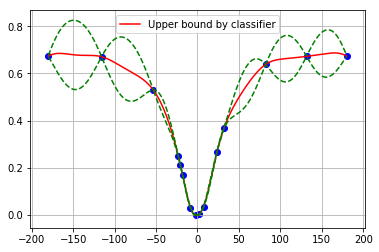

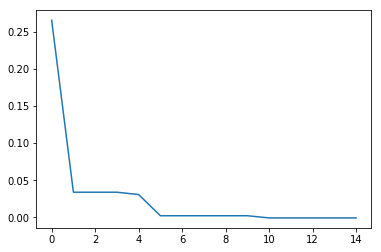

In [10]:
n_points = 15
angle_bound = (-180.0,180.0)
samples = list(range(n_points))
scores = []

min_score = np.log(2)
optimizer = Optimizer([angle_bound])
minimize_func = find_minimize_function(LogisticRegression())
for i in tqdm_notebook(range(n_points)):
    angle = optimizer.ask()
    f_val = minimize_func(angle[0])
    optimizer.tell(angle, f_val)
    print(angle,f_val)
    min_score = min(min_score,f_val)
    scores.append(min_score)
    
    
visualise(optimizer)
plt.plot(samples,scores)
